In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch

# pyro.set_rng_seed(98728292)

In [14]:
def g(x):
    return -(torch.sin(6 * np.pi * x) ** 2) + 6 * x**2 - 5 * x**4 + 3 / 2


def gen_data():
    l = 30
    x = (torch.arange(1, l + 1) - 1) / (l - 1)
    y = g(x) + np.sqrt(0.01) * torch.randn(len(x))
    permutation = torch.randperm(len(x))
    x_shuffle = x[permutation]
    y_shuffle = y[permutation]
    x_train = x_shuffle[:20]
    y_train = y_shuffle[:20]
    x_eval = x_shuffle[20:]
    y_eval = y_shuffle[20:]
    return x_train, y_train, x_eval, y_eval


def neg_log_likelihood(x, y, GP):
    kernel = GP.kernel
    noise_y = GP.noise
    n = len(y)
    K = kernel.forward(x)
    like1 = 1 / 2 * y @ torch.linalg.inv(noise_y * torch.eye(n) + K) @ y
    like2 = 1 / 2 * torch.log(torch.linalg.det(noise_y * torch.eye(n) + K))
    like3 = n / 2 * torch.log(2 * torch.tensor(np.pi))
    return like1 + like2 + like3


def neg_likelihood_prior_joint(x, y, GP, priors):
    params = [
        GP.noise,
        kernel.kern0.lengthscale,
        kernel.kern0.variance,
        kernel.kern1.variance,
        kernel.kern1.period,
        kernel.kern1.lengthscale,
    ]
    neg_likelihood = neg_log_likelihood(x, y, GP)
    log_prob_prior = torch.tensor(0.0)
    for dist, value in zip(priors, params):
        log_prob_prior += dist.log_prob(value)
    return neg_likelihood - log_prob_prior

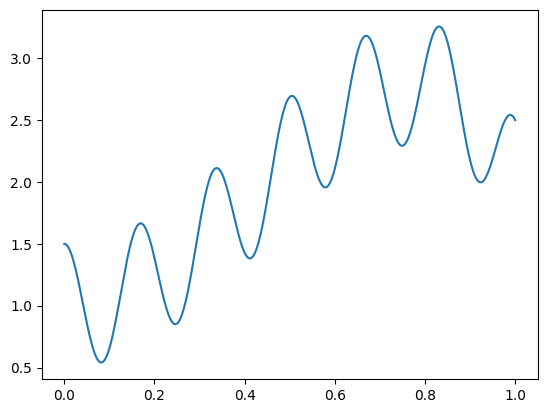

In [15]:
# Plot of data generating function
xs = torch.linspace(0, 1.0, 500)
ys = g(xs)
plt.plot(xs, ys)

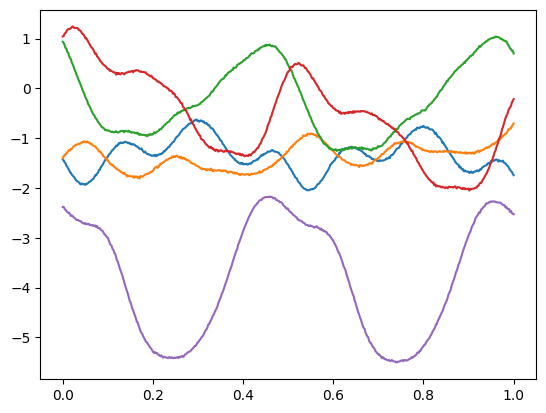

In [16]:
x_train, y_train, x_test, y_test = gen_data()

# Defining our kernel to draw samples
rbf = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
)
periodic = gp.kernels.Periodic(
    input_dim=1,
    period=torch.tensor(0.5),
    lengthscale=torch.tensor(1.0),
    variance=torch.tensor(1.0),
)
kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)
gpr = gp.models.GPRegression(x_train, y_train, kernel=kernel, noise=torch.tensor(0.01))

# Samples from the GP
n_samples = 5
n_points = 500
xs = torch.linspace(0.0, 1.0, n_points)
cov = kernel.forward(xs)
samples = dist.MultivariateNormal(
    torch.zeros(n_points),
    covariance_matrix=cov + torch.diag(torch.ones(n_points) * 0.0001),
).sample(sample_shape=(n_samples,))

for s in samples:
    plt.plot(xs, s)
plt.savefig("B1_GP_samples.png")

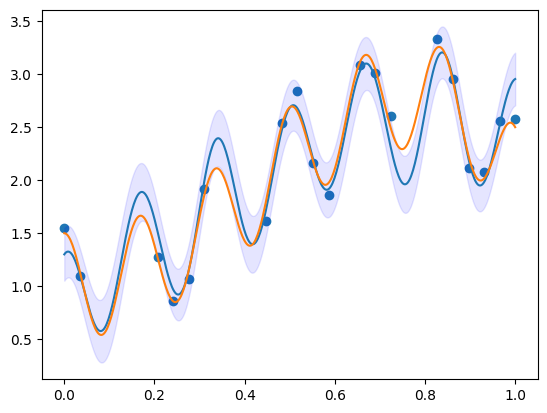

In [17]:
# Just a quick

with torch.no_grad():
    mean, cov = gpr(xs, noiseless=False)

plt.scatter(x_train, y_train)
plt.plot(xs, mean)
plt.plot(xs, ys)
plt.fill_between(
    xs,
    mean + torch.sqrt(cov) * 2.0,
    mean - torch.sqrt(cov) * 2.0,
    color="blue",
    alpha=0.1,
    label="95% CI",
)

In [6]:
losses_list = []
neg_likelihood_prior_joints_list = []
test_loglikelihoods = []
GPRs = []
# rbf_lengthscale_MAPs = []
# rbf_variance_MAPs = []
# periodic_period_MAPs = []
# periodic_lengthscale_MAPs = []
# periodic_variance_MAPs = []
# noise_MAPs = []
generated_data_list = []

for i in range(20):
    print("Beginning iteration", i)
    pyro.clear_param_store()
    x_train, y_train, x_test, y_test = gen_data()
    generated_data_list.append((x_train, y_train, x_test, y_test))

    # Defining our kernels and GP-model
    rbf = gp.kernels.RBF(
        input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.9)
    )
    periodic = gp.kernels.Periodic(
        input_dim=1,
        period=torch.tensor(0.5),
        lengthscale=torch.tensor(1.0),
        variance=torch.tensor(1.0),
    )
    kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)
    gpr = gp.models.GPRegression(
        x_train, y_train, kernel=kernel, noise=torch.tensor(0.01)
    )

    # Putting priors on our kernel parameters
    gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.kernel.kern1.period = pyro.nn.PyroSample(dist.Exponential(4.0))
    gpr.kernel.kern1.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 1.0))
    gpr.kernel.kern1.variance = pyro.nn.PyroSample(dist.LogNormal(1.0, 1.0))
    gpr.noise = pyro.nn.PyroSample(dist.Gamma(1.0, 1.0))
    priors = [
        dist.Gamma(1, 1),
        dist.LogNormal(0, 1),
        dist.LogNormal(1, 1),
        dist.LogNormal(1, 1),
        dist.Exponential(4.0),
        dist.LogNormal(0, 1),
    ]

    # SVI with delta distribution as guide
    optimizer = torch.optim.Adam(gpr.parameters(), lr=0.001)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    losses = []
    neg_likelihood_prior_joints = []
    num_steps = 3000
    for i in range(num_steps):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        gpr.set_mode("guide")
        neg_likelihood_prior_joints.append(
            neg_likelihood_prior_joint(x_train, y_train, gpr, priors).detach().numpy()
        )
        gpr.set_mode("model")

    gpr.set_mode("guide")
    losses_list.append(losses)
    neg_likelihood_prior_joints_list.append(neg_likelihood_prior_joints)
    test_loglikelihoods.append(-neg_log_likelihood(x_test, y_test, gpr))
    # rbf_lengthscale_MAPs.append(gpr.kernel.kern0.lengthscale)
    # rbf_variance_MAPs.append(gpr.kernel.kern0.variance)
    # periodic_period_MAPs.append(gpr.kernel.kern1.period)
    # periodic_lengthscale_MAPs.append(gpr.kernel.kern1.lengthscale)
    # periodic_variance_MAPs.append(gpr.kernel.kern1.variance)
    # noise_MAPs.append(gpr.noise)
    GPRs.append(gpr)

Beginning iteration 0
Beginning iteration 1
Beginning iteration 2
Beginning iteration 3
Beginning iteration 4
Beginning iteration 5
Beginning iteration 6
Beginning iteration 7
Beginning iteration 8
Beginning iteration 9
Beginning iteration 10
Beginning iteration 11
Beginning iteration 12
Beginning iteration 13
Beginning iteration 14
Beginning iteration 15
Beginning iteration 16
Beginning iteration 17
Beginning iteration 18
Beginning iteration 19


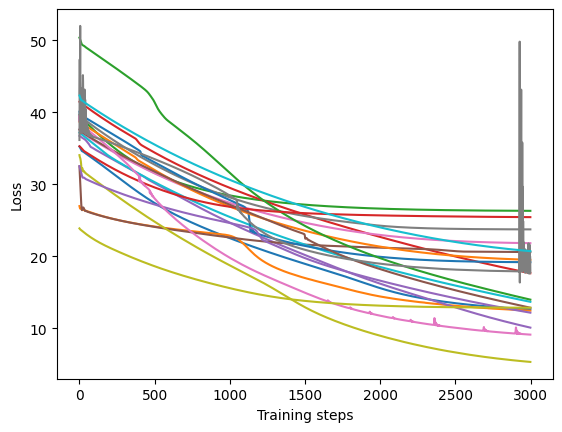

In [7]:
plt.figure()
plt.xlabel("Training steps")
plt.ylabel("Loss")
for l in losses_list:
    plt.plot(l)

# plt.savefig('B1_loss.png')

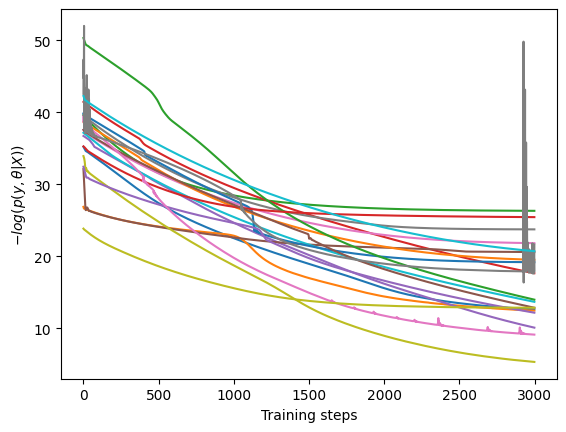

In [8]:
plt.figure()
plt.xlabel("Training steps")
plt.ylabel(r"$-log(p(y, \theta | X))$")
for l in neg_likelihood_prior_joints_list:
    plt.plot(l)

# plt.savefig('B1_neg_likelihood_joints.png')

In [9]:
[x.detach().item() for x in test_loglikelihoods]

[-9.087924003601074,
 -9.795509338378906,
 -10.713658332824707,
 -9.608424186706543,
 -6.261539459228516,
 -13.784283638000488,
 -9.20821475982666,
 -10.984378814697266,
 -4.452658653259277,
 -9.769182205200195,
 -11.607624053955078,
 -10.786937713623047,
 -9.270963668823242,
 -11.48511028289795,
 -9.351458549499512,
 -10.980342864990234,
 -9.249399185180664,
 -9.961273193359375,
 -12.670126914978027,
 -13.13787841796875]

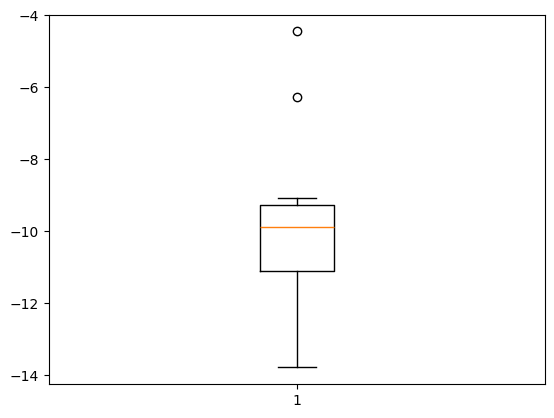

In [10]:
plt.boxplot([x.detach().item() for x in test_loglikelihoods]);

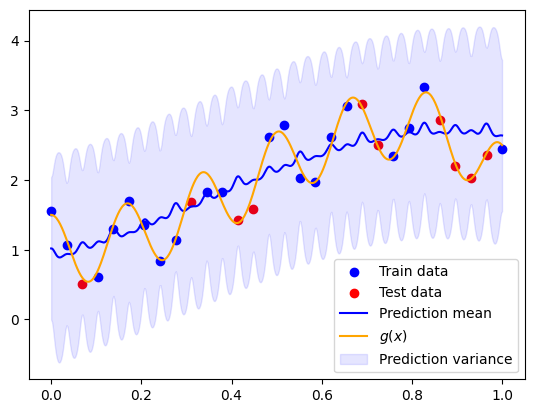

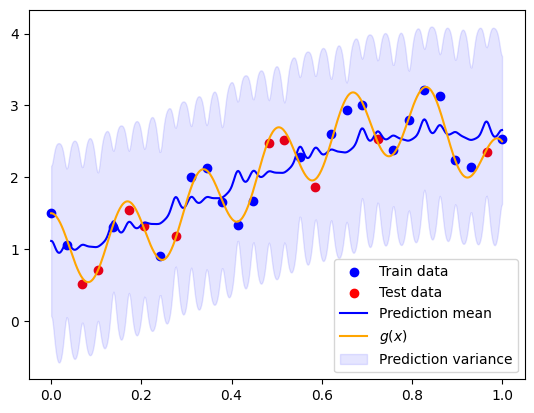

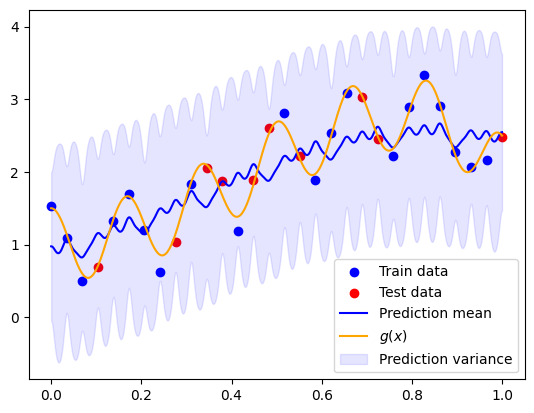

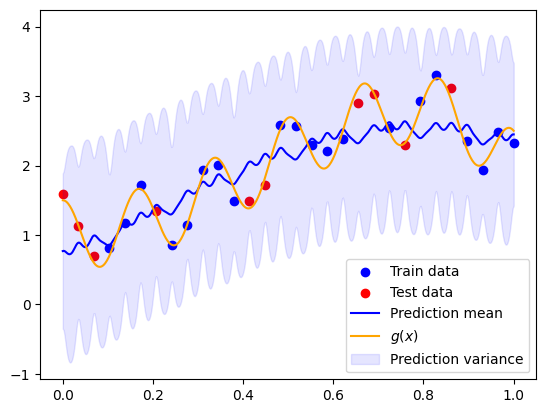

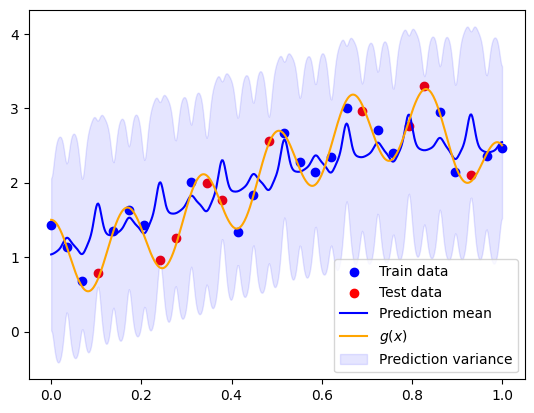

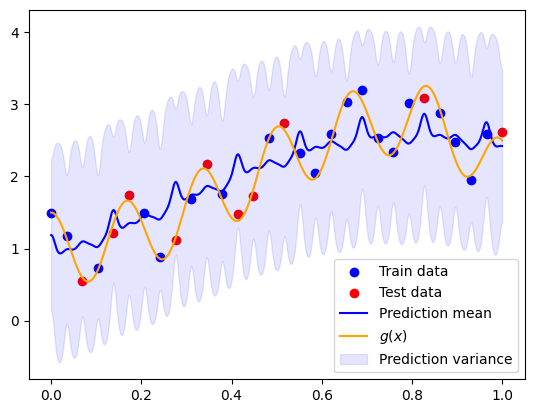

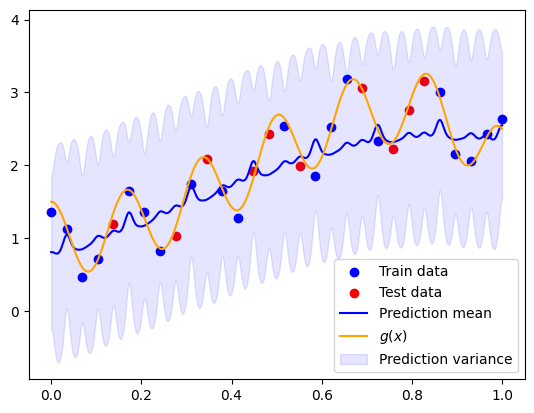

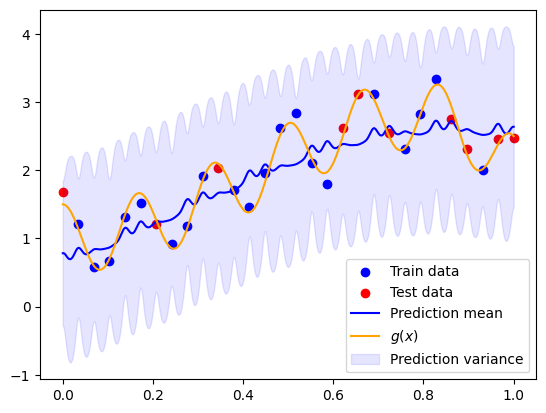

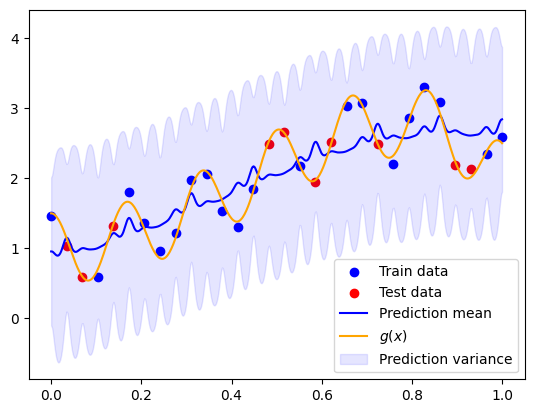

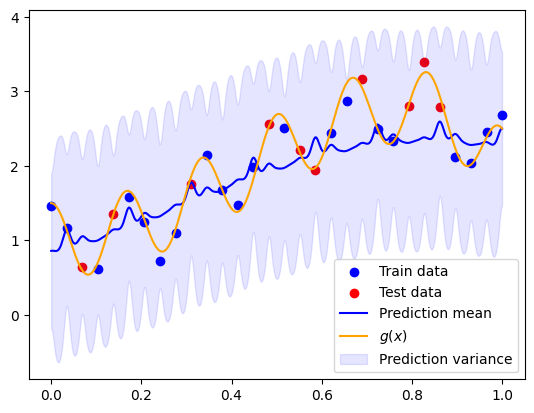

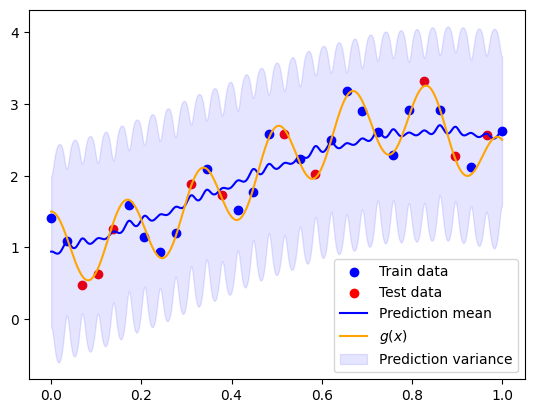

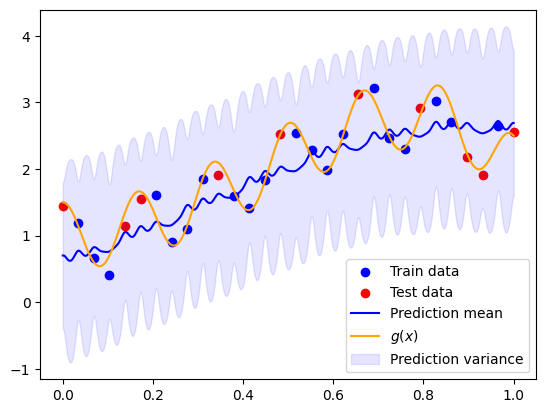

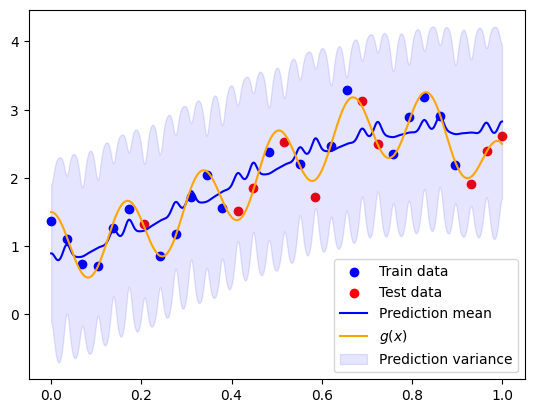

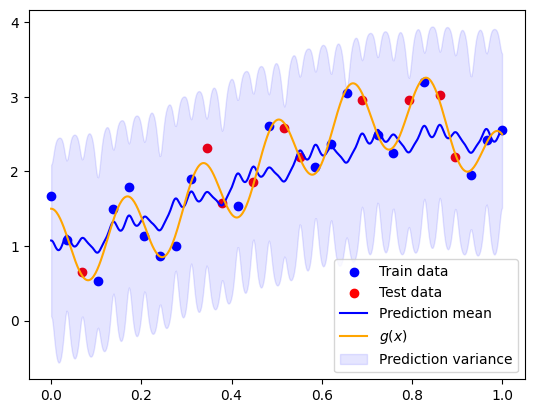

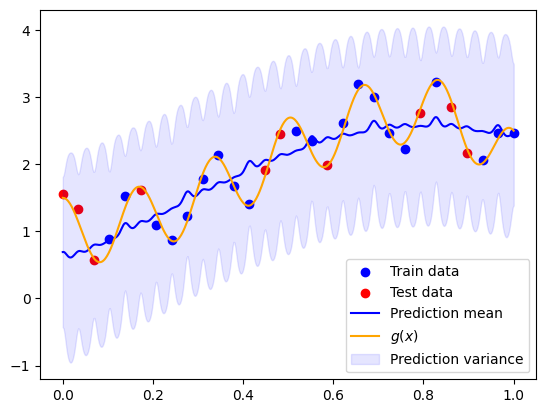

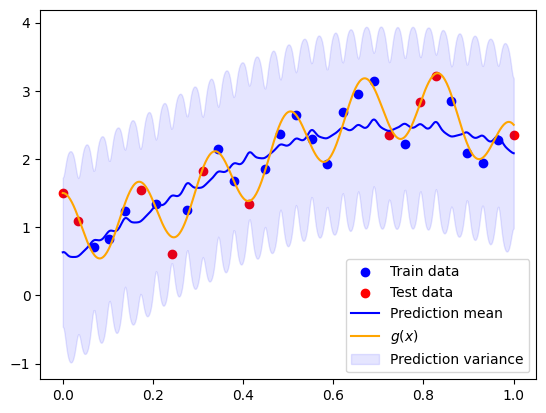

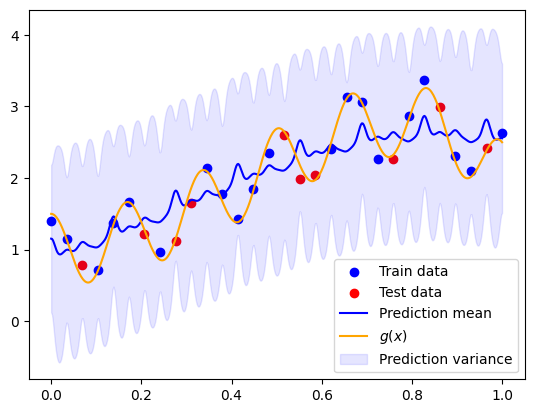

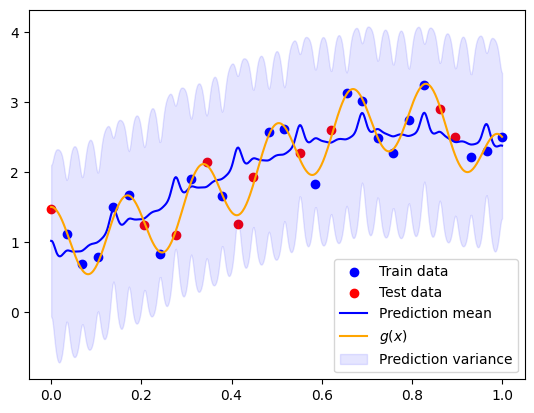

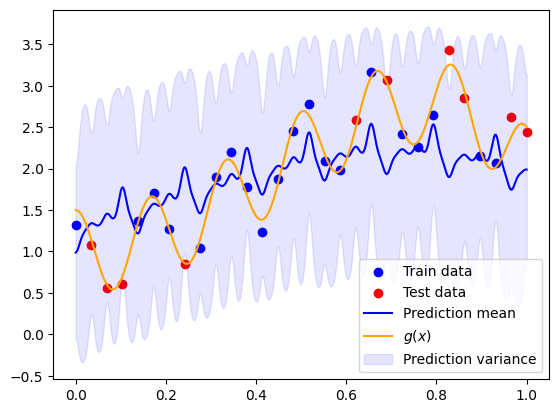

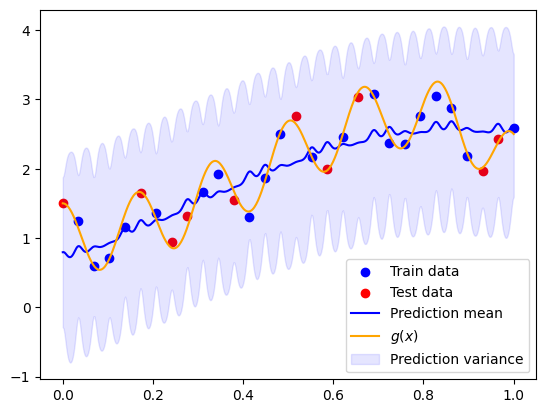

In [11]:
for i, gauss_p in enumerate(GPRs):
    gauss_p.set_mode("guide")
    with torch.no_grad():
        mean, cov = gauss_p(xs, noiseless=False)
    plt.figure()
    plt.scatter(
        generated_data_list[i][0],
        generated_data_list[i][1],
        color="blue",
        label="Train data",
    )  # plot train data
    plt.scatter(
        generated_data_list[i][2],
        generated_data_list[i][3],
        color="red",
        label="Test data",
    )  # plot test data
    plt.plot(xs, mean, color="blue", label="Prediction mean")  # plot mean
    plt.plot(xs, ys, color="orange", label=r"$g(x)$")  # plot g(x)
    plt.fill_between(
        xs,
        mean + torch.sqrt(cov) * 1.95,
        mean - torch.sqrt(cov) * 1.95,
        color="blue",
        alpha=0.1,
        label="Prediction variance",
    )  # plot var
    plt.legend()
    if i == 6:
        plt.savefig("GP_MAP_fit.png")

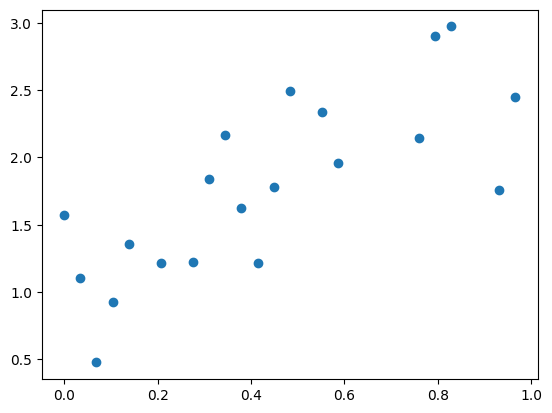

In [ ]:
# Example of train data
plt.scatter(generated_data_list[0][0], generated_data_list[0][1])

In [32]:
GPRs[0].set_mode("guide")
print(GPRs[0].kernel.kern0.lengthscale)
print(GPRs[0].kernel.kern0.variance)
print(GPRs[0].kernel.kern1.period)
print(GPRs[0].kernel.kern1.lengthscale)
print(GPRs[0].kernel.kern1.variance)

tensor(0.3792, grad_fn=<ExpandBackward0>)
tensor(1.5470, grad_fn=<ExpandBackward0>)
tensor(0.4945, grad_fn=<ExpandBackward0>)
tensor(0.7283, grad_fn=<ExpandBackward0>)
tensor(0.6971, grad_fn=<ExpandBackward0>)
